<div style="text-align: left"> <b> 01/12/2023 </b> <span style="float: right"> <b> de Charrin Théotime </b> - MVA </span></div>

# TP3 - Échantillonnage Hasting-Metropolis et Gibbs

In [709]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sklearn 
import math
import scipy.stats as stats
import sklearn.cluster as cluster
from numba import jit

In [710]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

## Question 2 - Générer de la data synthétique

In [714]:
#D'après l'énoncé
PRIOR={
    "v0_dbar":1,
    "s_v0":0.1**2,
    "t0_dbar":1,
    "s_t0":1**2,
    #m contrôle la variance des Wishart
    "m":6.5,
    "v":np.pi
}

#Paramètres fixés. On considère que sigma_x représente sigma^2_x
FIXED={
    "p0_bar":20,
    "sigma_p0":1,
    "p0":np.random.normal(loc=FIXED['p0_bar'],scale=np.sqrt(FIXED['sigma_p0'])),
    "sigma_v0":0.1**2,
    "sigma_t0":0.1**2,
}
N=100
#À partir de la Q2 on considère que tous les k_i sont égaux entre individus et égaux à 20. 
#De même, tous les timepoints sont communs entre individus et répartis uniformément sur [1,K]
K=20

##On génère notre ensemble de paramètres theta
THETA={
    "v0_bar":np.random.normal(PRIOR["v0_dbar"],scale=np.sqrt(PRIOR['s_v0'])),
    "t0_bar":np.random.normal(PRIOR["t0_dbar"],scale=np.sqrt(PRIOR['s_t0'])),
    "sigma_xi":stats.invwishart.rvs(df=PRIOR['v'],scale=PRIOR['m'],size=1),
    "sigma_tau":stats.invwishart.rvs(df=PRIOR['v'],scale=PRIOR['m'],size=1),
    "sigma":stats.invwishart.rvs(df=PRIOR['v'],scale=PRIOR['m'],size=1)
}

In [715]:
FIXED['p0'],v0,t0

(21.287986227962868, 1.1224162507359736, 0.6117705449837577)

In [716]:
p0=FIXED['p0']
v0=np.random.normal(loc=THETA['v0_bar'],scale=np.sqrt(FIXED['sigma_v0']))
t0=np.random.normal(loc=THETA['t0_bar'],scale=np.sqrt(FIXED['sigma_t0']))

def d(t,p0=p0,v0=v0,t0=t0):
    return p0+v0*(t-t0)

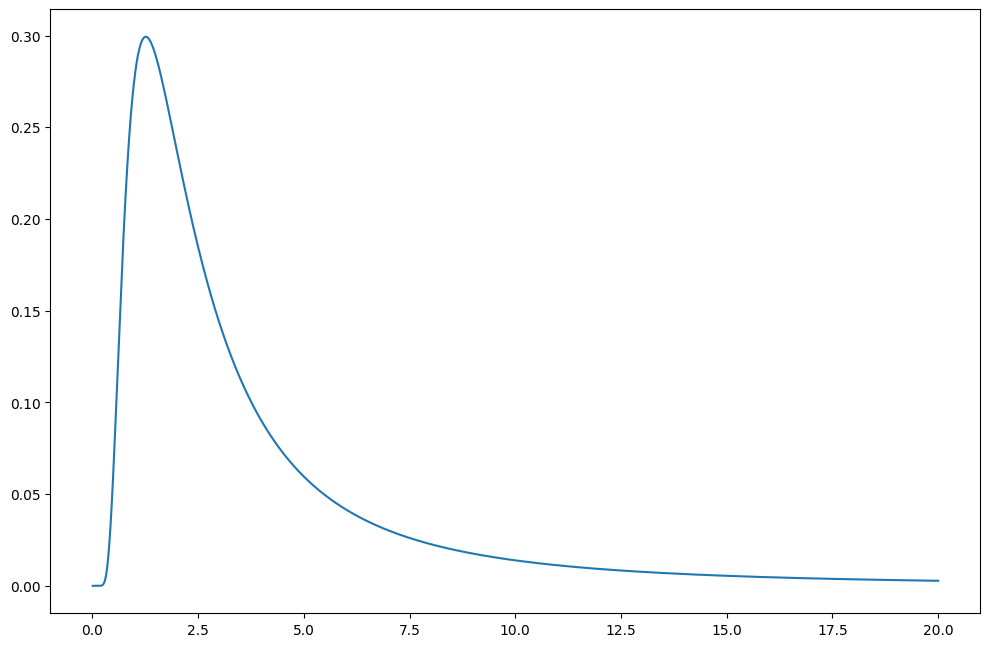

In [717]:
x=np.linspace(0.01,20,10000)
iw=stats.invwishart.pdf(x,df=PRIOR['v'],scale=PRIOR['m'])
plt.plot(x,iw)
plt.show()

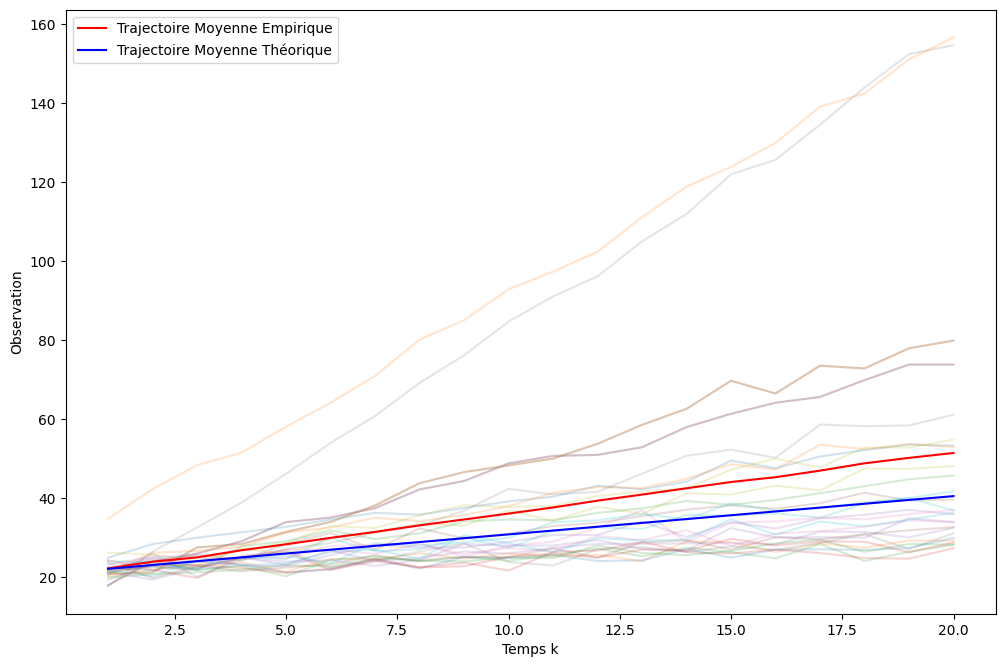

In [719]:
##On génère un sample de N=100 individus avec nos paramètres
N=100
Y=np.zeros((N,K))
xi=np.random.normal(loc=0,scale=np.sqrt(THETA['sigma_xi']),size=N)
alpha=np.exp(xi)
eps=np.random.normal(loc=0,scale=np.sqrt(THETA['sigma']),size=(N,K))
tau=np.random.normal(loc=0, scale=np.sqrt(THETA['sigma_tau']),size=N)

#On crée le dictionnaire associé
LATENT={
    "v0":v0,
    "t0":t0,
    "alpha":alpha,
    "tau":tau,
    "eps":eps
}

column=np.ones(N)
for j in np.arange(0,K):
    indiv_trajectory=alpha*((j+1)*column-t0*column-tau)+t0*column
    Y[:,j]=d(indiv_trajectory)+eps[:,j]


#Plot quelques trajectoires random et la trajectoire moyenne.
fig,ax=plt.subplots()
for j in np.random.choice(N,30):
    ax.plot(np.arange(1,K+1),Y[j,:],alpha=0.2)
ax.plot(np.arange(1,K+1),np.mean(Y,axis=0),label='Trajectoire Moyenne Empirique',c='red')
ax.plot(np.arange(1,K+1),d(np.arange(1,K+1)),label='Trajectoire Moyenne Théorique',c='blue')
ax.set_xlabel('Temps k')
ax.set_ylabel('Observation')
ax.legend()
plt.show()

La forte variance du paramètre de dilatation $\alpha$ qui est exponentiellement $\propto$ à $\xi$ (qui suit une Normale pouvant prendre des variances de 15-20) fait qu'on a des trajectoires très différentes sur une "petite" cohorte. Similairement, les moyennes théoriques et empiriques sont assez éloignées.

In [733]:
def log_post(z0,y,theta,prior):
    #On suppose z est de forme (2N+2), (t0,v0,(xi,tau)_i)
    #theta et prior sont des dicts
    N=z0.shape[0]
    z_pop=z[:2]
    xi=z[2:N+2]
    tau=z[N+2:]
    l_y=1
    l_z=1
    l_theta=1
    l=l_y+l_z+l_theta
    return l


#def SRWMH_sampler(z0,theta,prior):

Pour tester notre $\sigma_{\text{prop}}$ on prend une Sigma avec tout plein de valeurs. Fenêtres glissantes pendant la burn-in phase qui nous donnent le taux d'acceptation. S'il est pas bon on passe au prochain.  

Pour dépendance en $X_0$ on peut utiliser 
$$
c_i=\dfrac{\sum_{j=1}^{N-i}(x_j - \bar x)(x_{j+i}-\bar x)}{N-i} \propto
\dfrac{N}{\sum_1^N (x_j - \bar x)^2}
$$

In [700]:
def plot_chain_ensemble(
        chains, burnin=0.2, alpha=0.25, width=1600, height=800,
        margins={'l':20, 'r':20, 't':50, 'b':20}):
    plasma = [
        '#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b',
        '#ed7953', '#fb9f3a', '#fdca26', '#f0f921'
    ]

    n_chains = len(chains)
    n_samples = np.min([len(chain_) for chain_ in chains])

    chains = [chain_[:n_samples] for chain_ in chains]
    sample_steps = np.arange(n_samples)

    idx_burnin = int(burnin*n_samples)

    column_names = [f'chain{nc_}' for nc_ in range(n_chains)]
    df = pd.DataFrame(np.transpose(chains), columns=column_names)

    plots = [
        go.Scatter(
            x=df.index,
            y=df[col_],
            name=f"{col_}: {df[col_][df.index > idx_burnin].mean():0.2f} ± {df[col_][df.index > idx_burnin].std():0.2f}",
            line={'color':color_},

        )
        for col_, color_ in zip(df.columns, plasma)
    ]

    for col_, color_ in zip(df.columns, plasma):
        samples_posterior = df[col_]
        x_kde_posterior, y_kde_posterior = compute_kde(samples_posterior)
        plots.append(
            go.Scatter(
                x=y_kde_posterior,
                y=x_kde_posterior,
                mode = 'lines',
                line = {
                    'color': color_,
                    'width': 2
                },
                name='Posterior Distribution',
                xaxis="x2",
                yaxis="y2",
                fill="tozerox",
                fillcolor='rgba(100, 0, 100, 0.20)',
            )
        )
    
    title = 'Multichain Combination of Results. Expected Standard Normal, with 0.0 ± 1.0'
    layout = {
        'title': title, 
        'legend': {'orientation':'h'},
        'xaxis': {'domain': [0, 0.88], 'showgrid': False},
        'xaxis2': {'domain': [0.9, 1], 'showgrid': False},
        'yaxis2': {'anchor': 'x2', 'showgrid': False},
        "margin": margins,
        "width": width,
        "height": height,
        'plot_bgcolor': 'rgba(255, 255, 255, 1)',
        'paper_bgcolor': 'rgba(255, 255, 255, 1)'
    }
    
    fig = go.Figure(plots, layout=layout)
    fig.show()
     

    #Code de Jonathan Fraine pour visualiser la chaîne de Markov et plotter la densité sur le côté
    plasma = [
        '#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b',
        '#ed7953', '#fb9f3a', '#fdca26', '#f0f921'
    ]

    n_chains = len(chains)
    n_samples = np.min([len(chain_) for chain_ in chains])

    chains = [chain_[:n_samples] for chain_ in chains]
    sample_steps = np.arange(n_samples)

    idx_burnin = int(burnin*n_samples)

    column_names = [f'chain{nc_}' for nc_ in range(n_chains)]
    df = pd.DataFrame(np.transpose(chains), columns=column_names)

    plots = [
        go.Scatter(
            x=df.index,
            y=df[col_],
            name=f"{col_}: {df[col_][df.index > idx_burnin].mean():0.2f} ± {df[col_][df.index > idx_burnin].std():0.2f}",
            line={'color':color_},

        )
        for col_, color_ in zip(df.columns, plasma)
    ]

    for col_, color_ in zip(df.columns, plasma):
        samples_posterior = df[col_]
        x_kde_posterior, y_kde_posterior = compute_kde(samples_posterior)
        plots.append(
            go.Scatter(
                x=y_kde_posterior,
                y=x_kde_posterior,
                mode = 'lines',
                line = {
                    'color': color_,
                    'width': 2
                },
                name='Posterior Distribution',
                xaxis="x2",
                yaxis="y2",
                fill="tozerox",
                fillcolor='rgba(100, 0, 100, 0.20)',
            )
        )
    
    title = 'Multichain Combination of Results. Expected Standard Normal, with 0.0 ± 1.0'
    layout = {
        'title': title, 
        'legend': {'orientation':'h'},
        'xaxis': {'domain': [0, 0.88], 'showgrid': False},
        'xaxis2': {'domain': [0.9, 1], 'showgrid': False},
        'yaxis2': {'anchor': 'x2', 'showgrid': False},
        "margin": margins,
        "width": width,
        "height": height,
        'plot_bgcolor': 'rgba(255, 255, 255, 1)',
        'paper_bgcolor': 'rgba(255, 255, 255, 1)'
    }
    
    fig = go.Figure(plots, layout=layout)
    fig.show()